# Variational Inference

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using ForwardDiff
using SpecialFunctions
using Flux

#statistics
using Random 
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. Mean field approximation

### 1-1. Define functions

In [2]:
"""
    Gibbs sampler
"""
#Gibbs sampler
function Gibbs_sampler(data,model_params,n_samps)
    @unpack X,N = data
    @unpack β = model_params
    n_burnin = div(n_samps,10)
    SN = sum(X)
    μsamps = zeros(n_samps)
    λsamps = zeros(n_samps)
    μsamps[1] = 0
    λsamps[1] = 1
    @showprogress for s in 2:n_samps
        μsamps[s] = rand(Normal(λsamps[s-1]*SN/(λsamps[s-1]*N+1), 1/√(λsamps[s-1]*N+1)))
        λsamps[s] = rand(Gamma(N/2+1, 1/(β+sum((X.-μsamps[s-1]).^2)/2)))
    end
    return μsamps[n_burnin:end],λsamps[n_burnin:end]
end

"""
    Mean field approximation
"""
#computing ELBO
function ELBO(X,SN,SsqN,β,μhat,λhat,αhat,βhat)
    (
        -log(λhat)/2+1/2-αhat*log(βhat)+loggamma(αhat)-
        (αhat-1)*(digamma(αhat)-log(βhat))+αhat+
        N*(digamma(αhat)-log(βhat)-log(2*π))/2-
        αhat*(N/λhat+SsqN-2*μhat*SN+N*μhat^2)/βhat/2-
        (μhat^2+1/λhat)/2+log(β)-αhat*β/βhat
    )
end

#initialize the variational parameters
function initialize(β,N)
    return 0,1,1+N/2,β
end

#mean filed variational inference
function my_mf_VI(data,model_params,n_train,tol)
    @unpack X,N = data
    @unpack β = model_params
    μhat,λhat,αhat,βhat = initialize(β,N)
    SN = sum(X); SsqN = sum(X.^2)
    history = zeros(n_train+1); history[1] = ELBO(X,SN,SsqN,β,μhat,λhat,αhat,βhat)
    @showprogress for k in 1:n_train
        λhat = 1 + N*αhat/βhat
        μhat = SN * αhat/λhat/βhat
        βhat = β + SsqN/2 - μhat*SN + N*μhat^2/2 + N/λhat/2
        history[k+1] = ELBO(X,SN,SsqN,β,μhat,λhat,αhat,βhat)
        if abs(history[k+1]-history[k]) < tol
            return μhat,λhat,αhat,βhat,history[1:k+1]
            break
        end
    end
    return μhat,λhat,αhat,βhat,history
end

#variational posterior
function r(μ, λ, var_params)
    @unpack μhat,λhat,αhat,βhat = var_params
    return exp(logpdf(Normal(μhat, 1/√λhat), μ) + logpdf(Gamma(αhat, 1/βhat), λ))
end

#variational posterior sampling
function var_post_samps(var_params,n_samps)
    @unpack μhat,λhat,αhat,βhat = var_params
    μsamps = rand(Normal(μhat,1/√λhat),n_samps)
    λsamps = rand(Gamma(αhat,1/βhat),n_samps)
end

var_post_samps (generic function with 1 method)

### 1-2. Create data

In [3]:
#set the random seed
Random.seed!(42)

#true distribution and parameters
μ₁ = -2
μ₂ = 2
σ₁ = 1.5
σ₂ = 1.5
N = 20
mixture_normal = MixtureModel([Normal(μ₁, σ₁), Normal(μ₂, σ₂)])
X = rand(mixture_normal, N)
data = (X=X, N=N)

function true_pdf(x)
    pdf(mixture_normal, x)
end

true_pdf (generic function with 1 method)

### 1-3. Using Gibbs sampler

In [4]:
#Gibbs sampler for true posterior
β = 1e1
model_params = (β=β,)
n_samps = 5000
@time μsamps, λsamps = Gibbs_sampler(data,model_params,n_samps)
samps = (μsamps=μsamps, λsamps=λsamps)

  1.222202 seconds (3.27 M allocations: 181.164 MiB, 2.81% gc time, 99.93% compilation time)


(μsamps = [-0.26803440748830937, -0.5897901499750902, 0.22460655097378351, -0.009977926683244709, 1.0578993095026945, -1.2582105175472604, -0.43234149477847217, -0.9849970170505303, -0.4250530148918029, -0.07241546534188861  …  -0.5682518716342659, 0.2259981090166227, -0.6095918118772513, -0.0043664597740175615, -0.19727919894292317, -0.2555859333796353, 0.23090818826250986, 0.13537182700908196, -0.37341242421945436, -0.17273603569456533], λsamps = [0.10379746218654269, 0.06746468728709318, 0.21068477998489324, 0.16125431382634273, 0.18067692930939958, 0.12457034701347092, 0.17857263968387035, 0.24324582824565252, 0.28557903245568544, 0.1383391276745048  …  0.21255391557338288, 0.20230730022486038, 0.2181056484042931, 0.27321461618254866, 0.16427371033628604, 0.1951013227051927, 0.158829184097475, 0.22446207463397358, 0.27040750714578526, 0.26159102545290913])

### 1-4. Using mean field variational inference

In [5]:
#mean field variational inference
n_train = 1000
tol = 1e-6
@time μhat,λhat,αhat,βhat,history = my_mf_VI(data,model_params,n_train,tol)
var_params = (μhat=μhat, λhat=λhat, αhat=αhat, βhat=βhat)

  0.283250 seconds (717.95 k allocations: 41.942 MiB, 99.95% compilation time)


(μhat = -0.22470328645603985, λhat = 4.780334043972904, αhat = 11.0, βhat = 58.197341045762705)

### 1-5. Visualize the results

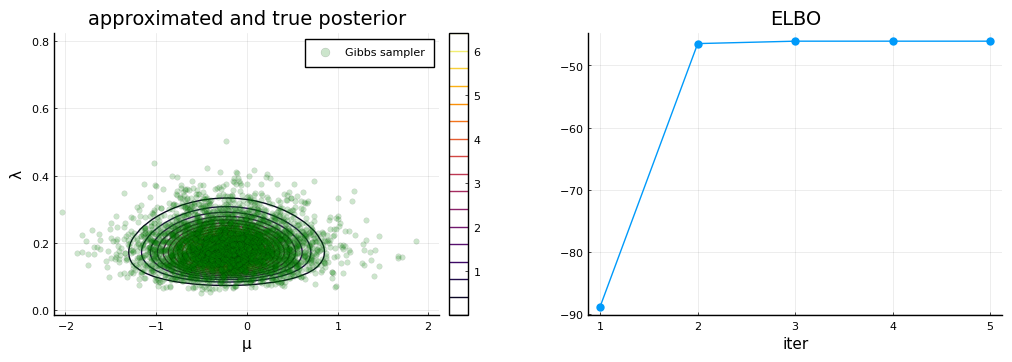

In [6]:
#visualize the variational and true posterior
p1 = plot(-2:0.1:2, 0.01:0.01:0.8, (μ,λ)->r(μ,λ,var_params), st=:contour, xlabel="μ", ylabel="λ",
    title="approximated and true posterior", xlim=[-2,2], ylim=[0.01, 0.8])
plot!(μsamps, λsamps, st=:scatter, alpha=0.2, label="Gibbs sampler", markerstrokewidth=0.2, color=:green)
p2 = plot(history, title="ELBO", xlabel="iter", label=false, marker=:circle, markerstrokewidth=0, markersize=6)
fig1 = plot(p1, p2, size=(1000, 350))
savefig(fig1, "figs-VI/fig1.png")

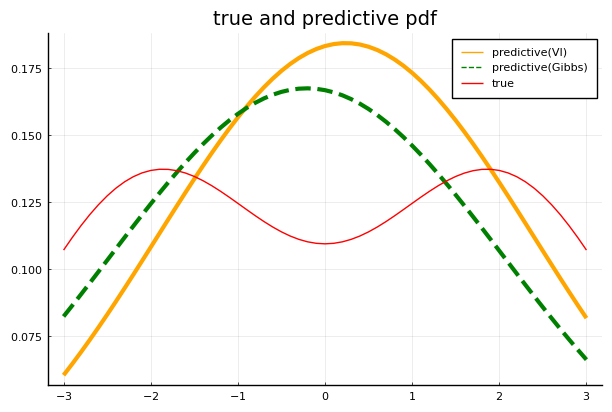

In [7]:
#predictive distribution
function pred(x,post_samps)
    @unpack μsamps,λsamps = post_samps
    n_samps = length(μsamps)
    preds = zeros(n_samps)
    for s in 1:n_samps
        preds[s] = pdf(Normal(μsamps[s],1/√λsamps[s]),x)
    end
    return mean(preds)
end

#visualize variational prediction
n_samps = 5000
μsamps, λsamps = var_post_samps(var_params, n_samps)
var_samps = (μsamps=μsamps, λsamps=λsamps)

#visualize the predictive pdf
xs = -3:0.1:3
fig2 = plot(xs, x->pred(x,var_samps), color=:orange, ls=:solid, lw=3, label="predictive(VI)")
plot!(xs, x->pred(x,samps), color=:green, ls=:dash, lw=3,label="predictive(Gibbs)")
plot!(xs, true_pdf, label="true", title="true and predictive pdf", color=:red)
savefig(fig2, "figs-VI/fig2.png")

## 2. Stochastic Variational Inference

### 2-1. Define functions

In [8]:
"""
    Hamiltonian Monte Carlo
"""
#one step of Störmer-Verlet method
function myStörmerVerlet(qvec, pvec, h, f)
    p_mid = pvec + h * f(qvec)/2;
    q_new = qvec + h * p_mid;
    p_new = p_mid + h * f(q_new)/2;
    return q_new, p_new
end

#update the position
function update(T, h, f, qvec, pvec)
    qvec_new = qvec
    pvec_new = pvec
    for t in 1:T
        qvec_new, pvec_new = myStörmerVerlet(qvec_new, pvec_new, h, f)
    end
    return qvec_new, pvec_new
end

#MH acceptance and rejection
function accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
    ΔH = H(xvec, pvec)-H(xvec_old, pvec_old)
    α = min(1.0, exp(-ΔH))
    u = rand()
    if u≤α
        return xvec, pvec
    else
        return xvec_old, pvec_old
    end
end

#log posterior
function logppost(wvec,data,model_params)
    @unpack X,Y,N = data
    @unpack m₀vec,s₀ = model_params
    sum([logpdf(Bernoulli(sigmoid(wvec[1]+wvec[2]*X[n])),Y[n]) for n in 1:N]) + logpdf(MvNormal(m₀vec,s₀),wvec)
end

#Hamiltonian Monte Carlo
function myHMC(data, model_params,n_samps, T, h)
    #initialization
    dw=2; wvec₀ = zeros(dw)
    n_burnin = div(n_samps,10)
    wsamps = zeros(dw, n_samps)
    wsamps[:,1] = wvec₀
    wvec = zeros(dw)
    pvec = zeros(dw)
    
    #Hamiltonian and potential
    U(wvec) = -logppost(wvec, data, model_params)
    ∇Uneg(wvec) = -ForwardDiff.gradient(U, wvec)
    H(wvec, pvec) = U(wvec) + norm(pvec)^2/2
    
    #sample
    wvec_old = wvec₀
    pvec_old = randn(dw)
    @showprogress for s in 2:n_samps
        pvec = randn(dw)
        wvec, pvec = update(T, h, ∇Uneg, wvec, pvec)
        wvec, pvec = accept_or_reject(wvec, wvec_old, pvec, pvec_old, H)
        wsamps[:,s] = wvec
        wvec_old = wvec
        pvec_old = pvec
    end
    return wsamps[:,n_burnin:end]
end  

"""
    Stochastic Vatiational Inference
"""
#split parameters
function split_params(vec)
    return vec[1:2], vec[3:end]
end

#reparametrize
function reparameterize(var_mean,var_logstd)
    var_mean + exp.(var_logstd) .* randn(2)
end

#logpmodel
function logpmodel(y,x,wvec)
    logpdf(Bernoulli(sigmoid(wvec[1]+wvec[2]*x)),y)
end

#ELBO
function ELBO(X,ηvec,minibatch,m₀vec,s₀,N)
    val = 0
    for n in minibatch
        var_mean,var_logstd = split_params(ηvec)
        val += logpmodel(Y[n],X[n],reparameterize(var_mean,var_logstd))
    end
    return N*val/length(minibatch)-(norm(ηvec[1:2]-m₀vec)^2+norm(exp.(ηvec[3:end]))^2)/2/s₀^2+sum(ηvec[3:end])+(1-2*log(s₀))
end
ELBO(X,ηvec,m₀vec,s₀,N) = ELBO(X,ηvec,1:length(X),m₀vec,s₀,N)

#create model
function create_model(X,m₀vec,s₀,N)
    ηvec = zeros(4)
    ps = Flux.params(ηvec)
    loss_func = minibatch->(-ELBO(X,ηvec,minibatch,m₀vec,s₀,N))
    return ηvec,ps,loss_func
end

#stochastic variational inference
function stochastic_variational_inference(data,model_params,n_train,minibatch_size)
    @unpack X,N = data
    @unpack m₀vec,s₀ = model_params
    opt = ADAM(0.01)
    history = zeros(n_train)
    ηvec,ps,loss_func = create_model(X,m₀vec,s₀,N)
    @showprogress for k in 1:n_train
        minibatch = sample(1:N,minibatch_size)
        Flux.train!(loss_func,ps,minibatch,opt)
        history[k] = ELBO(X,ηvec,m₀vec,s₀,N)
    end
    return ηvec,history
end

#variational poseterior
function r(wvec,ηvec)
    pdf(MvNormal(ηvec[1:2],exp.(ηvec[3:4])),wvec)
end

#variational posterior sample
function var_post_samps(ηvec,n_samps)
    wsamps = rand(MvNormal(ηvec[1:2],exp.(ηvec[3:end])),n_samps)
    return wsamps
end

var_post_samps (generic function with 1 method)

### 2-2. Create data 

In [9]:
#create data
Random.seed!(42)
w₁ = -4.0
w₂ = 4.0
w_true = (w₁=w₁,w₂=w₂)
N = 30
X = sort(rand(-10:10,N))
Y = [rand(Bernoulli(sigmoid(w₁+w₂*X[n]))) for n in 1:N]

function true_pdf(y,x,w_true)
    @unpack w₁,w₂ = w_true
    pdf(Bernoulli(sigmoid(w₁+w₂*x)),y)
end

true_pdf (generic function with 2 methods)

### 2-3. Using HMC

In [10]:
#data and model parameters
data = (X=X,Y=Y,N=N)
model_params = (m₀vec=ones(2),s₀=1)

#HMC parameters
n_samps = 10000
T = 100
h = 0.1
@time wsamps = myHMC(data, model_params,n_samps, T, h)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  7.982685 seconds (42.11 M allocations: 4.125 GiB, 10.83% gc time, 33.66% compilation time)


2×9001 Matrix{Float64}:
 -0.23039  0.085352  -0.0277403  0.577512  …  -0.419109  -0.397509  -0.539742
  2.19281  1.19014    2.53058    1.17709       1.54656    1.27549    1.3295

### 2-4. Using Stochastic Variational Inference

In [11]:
#data and model parameters
data = (X=X,Y=Y,N=N)
model_params = (m₀vec=zeros(2),s₀=1)

#training
n_train = 1000
minibatch_size = N
@time ηvec,history = stochastic_variational_inference(data,model_params,n_train,minibatch_size)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 31.473362 seconds (71.81 M allocations: 3.989 GiB, 4.40% gc time, 87.21% compilation time)


([-0.5149062267857577, 1.558143468687018, -0.29979440457797435, -0.82625987954309], [-42.25520012201338, -34.98679515804395, -5.139909028419662, -13.100128290466513, -4.926846537555709, -6.423385964018283, -7.300707376957995, -3.381583468126749, -3.8358713376758367, -3.890782356859858  …  -2.6884568833090716, -2.4446525590743695, -2.3775703568982625, -2.6318621894933747, -2.600414515013443, -2.9538968021415797, -3.5652155301811224, -3.461627214738459, -3.1354544716383455, -2.792182293414759])

### 2-5. Visualize the results

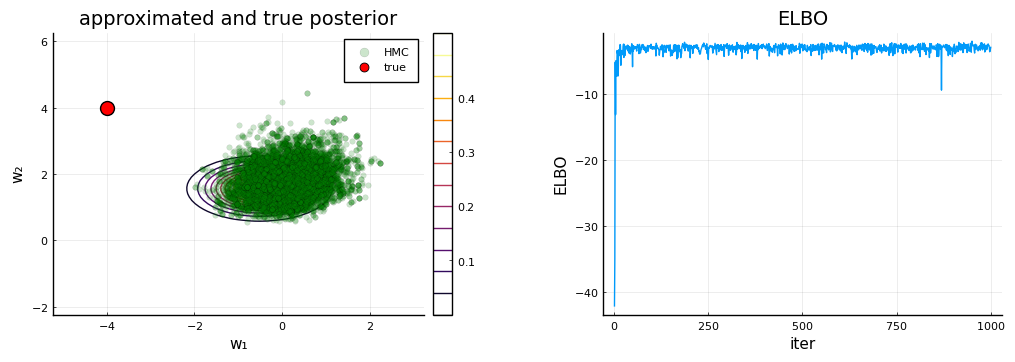

In [12]:
#true posterior and variational posterior
p1 = plot(-5:0.1:3,-2:0.1:6,(w₁,w₂)->r([w₁,w₂],ηvec), st=:contour, xlabel="w₁", ylabel="w₂",
    title="approximated and true posterior", xlim=[-5,3], ylim=[-2,6])
plot!(wsamps[1,:],wsamps[2,:],st=:scatter,alpha=0.2,label="HMC",markerstrokewidth=0.2,color=:green)
plot!([w₁,],[w₂,],st=:scatter,color=:red,label="true",markersize=10)
p2 = plot(history,xlabel="iter",ylabel="ELBO",title="ELBO",label=false)
fig3 = plot(p1, p2, size=(1000, 350))
savefig(fig3,"figs-VI/fig3.png")

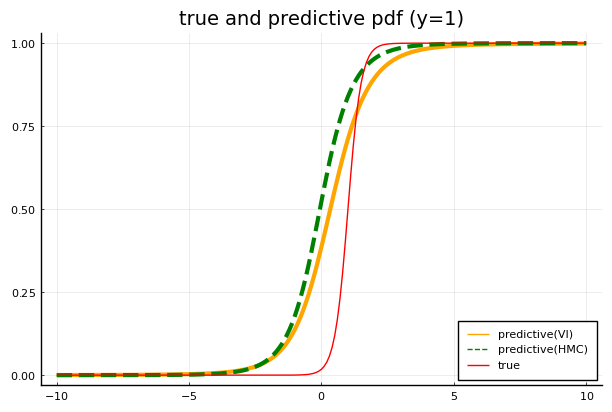

In [13]:
#predictive pdf
function pred(y,x,wsamps)
    n_samps = size(wsamps,2)
    preds = zeros(n_samps)
    for s in 1:n_samps
        preds[s] = pdf(Bernoulli(sigmoid(wsamps[1,s]+wsamps[2,s]*x)),y)
    end
    return mean(preds)
end

#variational posterior samples
n_samps = 5000
var_wsamps = var_post_samps(ηvec,n_samps)

#visualize the predictive pdf
xs = -10:0.1:10
fig4 = plot(xs,x->pred(1,x,var_wsamps),color=:orange,ls=:solid,lw=3,label="predictive(VI)",legend=:bottomright)
plot!(xs,x->pred(1,x,wsamps),color=:green,ls=:dash,lw=3,label="predictive(HMC)")
plot!(xs,x->true_pdf(1,x,w_true),label="true",title="true and predictive pdf (y=1)",color=:red)
savefig(fig4, "figs-VI/fig4.png")

## 3. Stochastic Variational Inference - Bayesian Neural Network

### 3-1. Create data

In [14]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

plot_data (generic function with 2 methods)

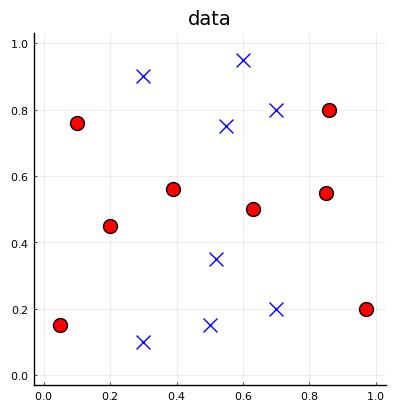

In [15]:
#create the data
N = 16
X = [
    0.3 0.52 0.3 0.50 0.60 0.7 0.70 0.55  0.85 0.10 0.05 0.20 0.39 0.63 0.86 0.97;
    0.1 0.35 0.9 0.15 0.95 0.2 0.80 0.75  0.55 0.76 0.15 0.45 0.56 0.50 0.80 0.20;
]
Y = vcat(zeros(div(N,2)), ones(div(N,2)))
data = (X=X,Y=Y,N=N)

#plot the data
fig5 = plot_data(X,Y)
savefig(fig5, "figs-VI/fig5.png")

### 3-2. Using Neural Network

Progress: 100%|█████████████████████████████████████████| Time: 0:00:227:05


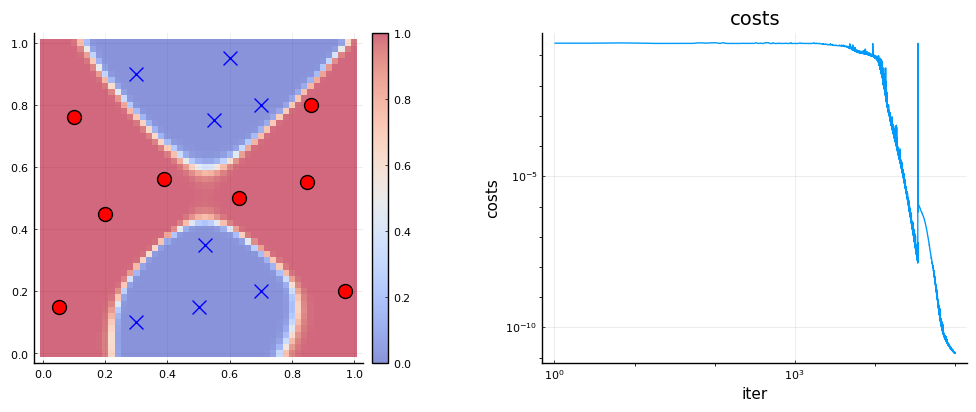

 23.037731 seconds (70.65 M allocations: 4.995 GiB, 5.24% gc time, 14.75% compilation time)


In [16]:
#set the random seed
Random.seed!(42)

#initialize the model
nn = Chain(
        Dense(2,10,sigmoid),
        Dense(10,10,sigmoid),
        Dense(10,1,sigmoid)
        )

#cost function 
function cost(x,y)
    (y-nn(x)[1])^2
end

#training
function my_train(data,nn,n_train)
    @unpack X,Y,N = data
    costs = zeros(n_train)
    opt = ADAM(0.01)
    n = 1
    @showprogress for k in 1:n_train
        n = rand(1:N)
        Flux.train!(cost,Flux.params(nn),[(X[:,n],Y[n])],opt)
        costs[k] = mean([cost(X[:,n],Y[n]) for n in 1:N])
    end
    return costs
end

#train the model
n_train = Int(1e5)
@time costs = my_train(data,nn,n_train)

#prediction 
function pred(x₁,x₂)
    nn([x₁,x₂])[1]
end

#visualize
p1 = plot(0:0.02:1, 0:0.02:1, pred, st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
p1 = plot_data(p1,X,Y)
p2 = plot(costs,xlabel="iter",ylabel="costs",title="costs",xscale=:log10,yscale=:log10,label=false)
fig6 = plot(p1,p2,size=(1000,400))
savefig(fig6, "figs-VI/fig6.png")

### 3-3. Using Stochastic Variational Inference

In [17]:
#create neural network
function create_nn()
    nn = Chain(
        Dense(2,10,sigmoid),
        Dense(10,10,sigmoid),
        Dense(10,1,sigmoid)
        )
    wvec,re_nn = Flux.destructure(nn)
    dw = length(wvec)
    return re_nn,zeros(2*dw),dw
end

#split parameters
function split_params(vec,dw)
    return vec[1:dw], vec[dw+1:end]
end

#reparametrize
function reparameterize(var_mean,var_logstd,dw)
    var_mean + exp.(var_logstd) .* randn(dw)
end

#logpmodel
function logpmodel(y,xvec,wvec,re_nn)
    logpdf(Bernoulli(re_nn(wvec)(xvec)[1]),y)
end

#ELBO
function ELBO(X,Y,ηvec,minibatch,w_prec,N,dw,re_nn)
    val = 0
    for n in minibatch
        var_mean,var_logstd = split_params(ηvec,dw)
        val += logpmodel(Y[n],X[:,n],reparameterize(var_mean,var_logstd,dw),re_nn)
    end
    return N*val/length(minibatch)-w_prec*(norm(ηvec[1:dw])^2+norm(exp.(ηvec[dw+1:end]))^2)/2+sum(ηvec[dw+1:end])+dw*(1+log(w_prec))/2
end
ELBO(X,Y,ηvec,w_prec,N,dw,re_nn) = ELBO(X,Y,ηvec,1:size(X,2),w_prec,N,dw,re_nn)

#create model
function create_model(X,Y,w_prec,N)
    re_nn,ηvec,dw = create_nn()
    ps = Flux.params(ηvec)
    loss_func = minibatch->(-ELBO(X,Y,ηvec,minibatch,w_prec,N,dw,re_nn))
    return re_nn,dw,ηvec,ps,loss_func
end

#stochastic variational inference
function stochastic_variational_inference(data,model_params,n_train,minibatch_size)
    @unpack X,N = data
    @unpack w_prec = model_params
    opt = ADAM(0.01)
    history = zeros(n_train)
    re_nn,dw,ηvec,ps,loss_func = create_model(X,Y,w_prec,N)
    @showprogress for k in 1:n_train
        minibatch = sample(1:N,minibatch_size)
        Flux.train!(loss_func,ps,minibatch,opt)
        history[k] = ELBO(X,Y,ηvec,w_prec,N,dw,re_nn)
    end
    return ηvec,history,re_nn
end

#variational posterior sample
function var_post_samps(ηvec,n_samps)
    dw = div(length(ηvec),2)
    wsamps = rand(MvNormal(ηvec[1:dw],exp.(ηvec[dw+1:end])),n_samps)
    return wsamps
end

#predictive dsitribution
function pred(xvec,ηvec,re_nn)
    n_samps = 1000
    wsamps = var_post_samps(ηvec,n_samps)
    preds = zeros(n_samps)
    @showprogress for s in 1:n_samps
        preds[s] = pdf(Bernoulli(re_nn(wsamps[:,s])(xvec)[1]),1)
    end
    return mean(preds)
end

pred (generic function with 2 methods)

In [18]:
#data and model parameters
data = (X=X,N=N)
model_params = (w_prec=0.1,)

#training
n_train = 1000
minibatch_size = 1
@time ηvec,history,re_nn = stochastic_variational_inference(data,model_params,n_train,minibatch_size)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  5.182378 seconds (12.79 M allocations: 926.605 MiB, 6.37% gc time, 58.39% compilation time)


([0.2283349347055913, -0.04154415619356009, 0.15276510453250777, 0.09788058632195648, -0.04621254341418157, -0.4119807341664427, -0.0014898631826462084, -0.11668652108687996, 0.06817672684598543, -0.0618550507533113  …  -0.11029574182201994, 0.0928907083605802, 0.11644584065771205, 0.10704382565149093, -0.056722967377904825, 0.10473210421249812, 0.1635337573996432, 5.6101490948964286e-5, 0.05577057861066291, -0.43030617742492194], [-118.40132139426387, -124.52904602267147, -125.6726569414761, -116.934924107432, -119.69155630586451, -121.41436298156027, -114.10623633329281, -105.85431928262203, -113.28848080303898, -105.31901563484618  …  -31.362243624483483, -23.798220750336142, -28.523319425081297, -27.384795188368088, -27.129096254259494, -24.361831157128535, -21.71924617216267, -21.31915843864138, -18.381760584390676, -31.376459156402177], Flux.var"#62#64"{Chain{Tuple{Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof

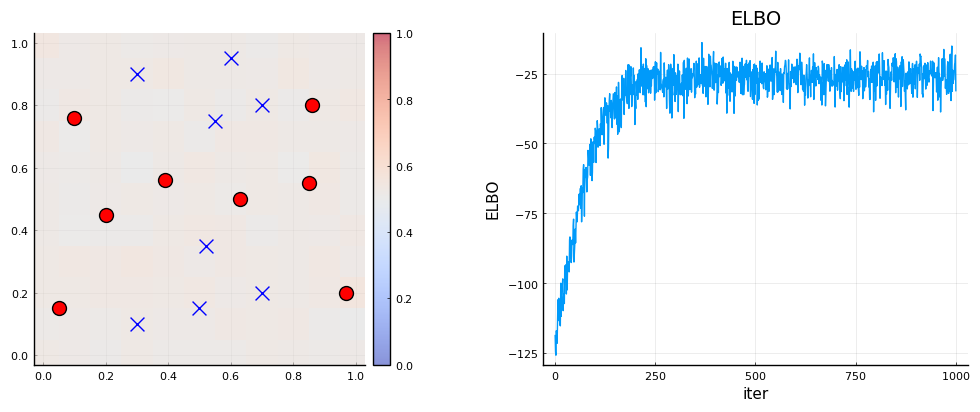

In [19]:
#visualize
p1 = plot(0:0.1:1, 0:0.1:1, (x₁,x₂)->pred([x₁,x₂],ηvec,re_nn), 
    st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
p1 = plot_data(p1,X,Y)
p2 = plot(history,xlabel="iter",ylabel="ELBO",title="ELBO",label=false)
fig7 = plot(p1,p2,size=(1000,400))
savefig(fig7, "figs-VI/fig7.png")